# Transfer Learning Using PyTorch Lightning ⚡️

## Setting up PyTorch Lightning

For this tutorial, we need PyTorch Lightning

In [1]:
!nvidia-smi

Sun Apr 30 21:34:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          Off  | 00000000:01:00.0 Off |                  Off |
|  0%   54C    P0    62W / 150W |   3195MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Завершить все процессы, использующие ГПУ в нашей ОС
!fuser -k /dev/nvidia[0]

In [3]:
import os

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torchvision.models as models
from PIL import Image
# your favorite machine learning tracking tool
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms


## The Dataset 💿



In [4]:
class ClassificationDataset(Dataset):
    """
    Датасет с картинками, который производит изменения размера картинок,
    аугментации и преобразование в тензоры PyTorch
    """
    def __init__(self, img_paths, target, mode, rescale_size):
        super().__init__()
        # список файлов для загрузки
        self.files = img_paths
        
        # изменяем размер картинок датасета на указанный
        self.rescale_size = rescale_size
        
        # режим работы
        self.mode = mode
        self.available_modes = ['train', 'val', 'test']

        if self.mode not in self.available_modes:
            print(f"{self.mode} is not correct; correct modes: {self.available_modes}")
            raise NameError

        self.len_ = len(self.files)

        if self.mode != 'test':
            self.target = target
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.Resize(self.rescale_size),
            transforms.ToTensor(),
            # mean и std для набора данных ImageNet на котором были обучены 
            # предобученные сети из torchvision
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
            ])
        
            # transforms.Normalize делается для того, чтобы подогнать наши 
            # данные под данные на которых были предобучены наши нейронные сети
            # из torchvision.models они были обученные  на наборе данных 
            # ImageNet в документации по самому torchvision.models так же 
            # сказано https://pytorch.org/docs/stable/torchvision/models.html

            # All pre-trained models expect input images normalized in the same way,
            # i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), 
            # where H and W are expected to be at least 224. The images have to be
            # loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406]
            # and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:
            
            # И ниже код от самих разработчиков PyTorch
            # normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                      std=[0.229, 0.224, 0.225])

        # трансформация с аугментацией для обучающей выборки средствами PyTorch
        transform_augment = transforms.Compose([
            transforms.Resize(size=self.rescale_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(hue=.1, saturation=.1),
            transforms.ToTensor(),
            # mean и std для набора данных ImageNet на котором были обучены 
            # предобученные сети из torchvision
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
            ])

        x = self.load_sample(self.files[index])
        #x = np.array(x / 255, dtype='float32') *см. примечание ниже

        # У нас тр режима датасета 
        # DATA_MODES = ['train', 'val', 'test']
        # train - обучающая выборка на которой мы обучаем нейросеть 
        # (есть картинки и ответы к ним)
        # val - валидационная выборка на которой мы тестируем как хорошо
        #  нейросеть обучилась! (есть картинки и ответы к ним)
        # test - тестовая выборка на которой мы предсказываем ответы для
        #  скора в соревновании (есть картинки ответов нет!)

        if self.mode == 'test': # если тестовая выборка у нас нет ответов и
            x = transform(x)    # датасет не должен аугментировать картинки
            return x
        else:
            if self.mode == 'train': # аугментируем обучающую выборку
                x = transform_augment(x)
            else:
                x = transform(x) # не аугментируем валидационную выборку

            # для train или val выборок у нас есть ответы по классам
            y = self.target[index].item()

            return x, y

In [5]:
class ClassificationDataModule(pl.LightningDataModule):
    def __init__(self, df_train_all, img_path_col, target_col, df_test, val_size, rescale_size, batch_size, num_workers):
        super().__init__()

        # задаем параметры даталоадера
        self.rescale_size = rescale_size
        self.batch_size = batch_size
        self.num_workers = num_workers

        # задаем данные датасета
        train, val = train_test_split(df_train_all,
                                      test_size=val_size,
                                      random_state=42,
                                      stratify=df_train_all[target_col].values)

        train_paths = train[img_path_col].values
        train_target = train[target_col].values
        self.val_paths = val[img_path_col].values
        self.val_target = val[target_col].values
        test_paths = df_test[img_path_col].values

        self.train = ClassificationDataset(train_paths,
                                       train_target,
                                       mode='train',
                                       rescale_size=self.rescale_size)

        self.val = ClassificationDataset(self.val_paths,
                                     self.val_target,
                                     mode='val',
                                     rescale_size=self.rescale_size)

        self.test = ClassificationDataset(test_paths,
                                      None,
                                      mode='test',
                                      rescale_size=self.rescale_size)

    def prepare_data(self):
        pass

    def train_dataloader(self):
        return DataLoader(self.train,
                          batch_size=self.batch_size,
                          shuffle=True,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers)

    def test_by_val_dataloader(self):
        test_val = ClassificationDataset(self.val_paths,
                                     None,
                                     mode='test',
                                     rescale_size=self.rescale_size)

        return DataLoader(test_val,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers)


## Загрузка данных

In [6]:
train_all = pd.read_csv('RAVDESS_frames_set/train.csv')
test = pd.read_csv('RAVDESS_frames_set/test.csv')

In [7]:
def df_change_paths(df, path, path_col):
    df[path_col] =  path + '/' + df[path_col]

In [8]:
# меняем пути у train и test
path2datset = 'RAVDESS_frames_set'
df_change_paths(train_all, path2datset, path_col = 'image_path')
df_change_paths(test, path2datset, path_col = 'image_path')

In [9]:
train_all.emotion_class -= 1
test.emotion_class -= 1

In [10]:
train_all

,image_path,emotion_class
0,RAVDESS_frames_set/train/02-01-01-01-01-01-01_...,0
1,RAVDESS_frames_set/train/02-01-01-01-01-01-01_...,0
2,RAVDESS_frames_set/train/02-01-01-01-01-01-01_...,0
3,RAVDESS_frames_set/train/02-01-01-01-01-01-01_...,0
4,RAVDESS_frames_set/train/02-01-01-01-01-01-01_...,0
...,...,...
46066,RAVDESS_frames_set/train/02-02-06-02-02-02-19_...,5
46067,RAVDESS_frames_set/train/02-02-06-02-02-02-19_...,5
46068,RAVDESS_frames_set/train/02-02-06-02-02-02-19_...,5
46069,RAVDESS_frames_set/train/02-02-06-02-02-02-19_...,5


In [11]:
test

,image_path,emotion_class
0,RAVDESS_frames_set/test/02-01-01-01-01-01-20_f...,0
1,RAVDESS_frames_set/test/02-01-01-01-01-01-20_f...,0
2,RAVDESS_frames_set/test/02-01-01-01-01-01-20_f...,0
3,RAVDESS_frames_set/test/02-01-01-01-01-01-20_f...,0
4,RAVDESS_frames_set/test/02-01-01-01-01-01-20_f...,0
...,...,...
12900,RAVDESS_frames_set/test/02-02-06-02-02-02-24_f...,5
12901,RAVDESS_frames_set/test/02-02-06-02-02-02-24_f...,5
12902,RAVDESS_frames_set/test/02-02-06-02-02-02-24_f...,5
12903,RAVDESS_frames_set/test/02-02-06-02-02-02-24_f...,5


In [12]:
# число различных эмоций в датасете
emotion_num = len(train_all.emotion_class.unique())
emotion_num

8

## LightingModule - Define the System

Let us look at the model definition to see how transfer learning can be used with PyTorch Lightning.
In the `LitModel` class, we can use the pre-trained model provided by Torchvision as a feature extractor for our classification model. Here we are using ResNet-18. A list of pre-trained models provided by PyTorch Lightning can be found here.
- When `pretrained=True`, we use the pre-trained weights; otherwise, the weights are initialized randomly.
- If `.eval()` is used, then the layers are frozen. 
- A single `Linear` layer is used as the output layer. We can have multiple layers stacked over the `feature_extractor`.

Setting the `transfer` argument to `True` will enable transfer learning.

In [13]:
# class LitModel(pl.LightningModule):
#     def __init__(self, input_shape, classes_num, learning_rate=1e-4, transfer=False):
#         super().__init__()

#         # log hyperparameters
#         self.save_hyperparameters()
#         self.learning_rate = learning_rate
#         self.dim = input_shape
#         self.step = 0

#         # transfer learning if pretrained=True
#         self.neural_net = models.resnet50(pretrained=transfer)
#         self.neural_net.fc = nn.Linear(2048, classes_num)

#         self.criterion = nn.functional.cross_entropy
#         # self.metric = f1

#     # will be used during inference
#     def forward(self, x):
#         return self.neural_net(x)

#     # def training_step(self, batch):
#     #     batch, gt = batch[0], batch[1]
#     #     out = self.forward(batch)
#     #     out, gt = torch.argmax(out, dim=1).float(), torch.flatten(gt).float()

#     #     # Write-Overwrites
#     #     # file1 = open("myfile.txt", "w")  # write mode
#     #     # file1.write(f"{out} \n")
#     #     # file1.write(f"{gt} \n")
#     #     # file1.close()

#     #     loss = self.criterion(out, gt)

#     #     # metric_value = self.metric(out, gt)

#     #     self.step += 1

#     #     self.log("train_loss", loss)
#     #     # self.log("train_f1", metric_value)
#     #     self.log("train_step", self.step)

#     #     return loss

#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         y_pred = self(x)
        
#         loss = self.criterion(y_pred, y)
#         self.log("train_loss", loss)

#         return loss

#     # def validation_step(self, batch, batch_idx):
#     #     batch, gt = batch[0], batch[1]
#     #     out = self.forward(batch)
#     #     out, gt = torch.argmax(out, dim=1).float(), torch.flatten(gt).float()

#     #     # Write-Overwrites
#     #     # file1 = open("myfile.txt", "w")  # write mode
#     #     # file1.write(f"{out} \n")
#     #     # file1.write(f"{gt} \n")
#     #     # file1.close()

#     #     loss = self.criterion(out, gt)

#     #     self.log("val_loss", loss)

#     #     # metric_value = self.metric(out, gt)
#     #     # self.log("val_f1", metric_value)

#     #     return loss

#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         y_pred = self(x)
        
#         # Write-Overwrites
#         file1 = open("myfile.txt", "w")  # write mode
#         file1.write(f"{y_pred} \n")
#         file1.write(f"{y} \n")
#         file1.close()
        
#         loss = self.criterion(y_pred, y)
#         self.log("val_loss", loss)

#         return loss

#     # def predict_step(self, batch, batch_idx):
#     #     return self(batch).tolist()

#     # def test_step(self, batch, batch_idx):
#     #     batch, gt = batch[0], batch[1]
#     #     out = self.forward(batch)
#     #     out, gt = torch.argmax(out, dim=1).float(), torch.flatten(gt).float()

#     #     # Write-Overwrites
#     #     # file1 = open("myfile.txt", "w")  # write mode
#     #     # file1.write(f"{out} \n")
#     #     # file1.write(f"{gt} \n")
#     #     # file1.close()

#     #     loss = self.criterion(out, gt)

#     #     return loss  # {"loss": loss, "outputs": out, "gt": gt}

#     def test_step(self, batch, batch_idx):
#         x, y = batch
#         y_pred = self(x)
        
#         # Write-Overwrites
#         file1 = open("myfile.txt", "w")  # write mode
#         file1.write(f"{y_pred} \n")
#         file1.write(f"{y} \n")
#         file1.close()
        
#         loss = self.criterion(y_pred, y)
#         self.log("test_loss : ", loss)

#         return loss

#     # def test_epoch_end(self, outputs):
#     #     loss = torch.stack([x['loss'].float() for x in outputs]).mean()
#     #     output = torch.cat([x['outputs'].float() for x in outputs], dim=0)

#     #     gts = torch.cat([x['gt'].float() for x in outputs], dim=0)

#     #     self.log("test_loss", loss)
#     #     # metric_value = self.metric(output, gts)
#     #     # self.log("test_f1", metric_value)

#     #     self.test_gts = gts
#     #     self.test_output = output

#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [14]:
from torchmetrics.classification import F1Score

f1 = F1Score(task="multiclass", num_classes=emotion_num)


class LitModel(pl.LightningModule):
    def __init__(self, input_shape, classes_num, learning_rate=1e-4, fc_only=False):
        super().__init__()

        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.dim = input_shape
        self.step = 0

        # transfer learning if pretrained=True
        self.neural_net = models.resnet50(pretrained=True)
        self.neural_net.fc = nn.Linear(2048, classes_num)

        if fc_only:
            self.set_trainable_fc_only()

        self.criterion = nn.functional.cross_entropy
        self.metric = f1

    def set_trainable_fc_only(self):
        # freeze params всей нейросети
        for param in self.neural_net.parameters():
            param.requires_grad = False

        # размораживаем веса для fc
        for param in self.neural_net.parameters():
            param.requires_grad = True

    # will be used during inference
    def forward(self, x):
        return self.neural_net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.forward(x)

        loss = self.criterion(y_pred, y)

        # training metrics
        preds = torch.argmax(y_pred, dim=1)
        metric_value = self.metric(preds, y)

        self.step += 1

        self.log("train_loss", loss)
        self.log("train_f1", metric_value)
        self.log("train_step", self.step)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.forward(x)

        loss = self.criterion(y_pred, y)

        # training metrics
        preds = torch.argmax(y_pred, dim=1)
        metric_value = self.metric(preds, y)

        self.log("val_loss", loss)
        self.log("val_f1", metric_value)

        return loss

    def predict_step(self, batch, batch_idx):
        y_pred = self.forward(x)
        preds = torch.argmax(y_pred, dim=1)
        return preds.tolist()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.forward(x)

        loss = self.criterion(y_pred, y)

        # training metrics
        preds = torch.argmax(y_pred, dim=1)

        return {"loss": loss, "outputs": preds, "gt": y}

    def test_epoch_end(self, outputs):
        loss = torch.stack([x['loss'].float() for x in outputs]).mean()
        output = torch.cat([x['outputs'].float() for x in outputs], dim=0)

        gts = torch.cat([x['gt'].float() for x in outputs], dim=0)

        self.log("test_loss", loss)
        mse = self.metric(output, gts)
        self.log("test_f1", mse)

        self.test_gts = gts
        self.test_output = output

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


## Train your Model 🏋️‍♂️

### Вначале определим оптимальный learning rate для нашей модели!

In [15]:
transfer_flag=False

In [16]:
# создаем загрузчик данных
dm = ClassificationDataModule(df_train_all=train_all,
                          img_path_col='image_path',
                          target_col='emotion_class',
                          df_test=test,
                          val_size=0.2,
                          rescale_size=(224, 224),
                          batch_size=64,
                          num_workers=12)

# Небольшая проверка работы загрузчика данных

In [17]:
data_loader = dm.train_dataloader()
image , label = next(iter(data_loader))

In [18]:
image.shape

torch.Size([64, 3, 224, 224])

In [19]:
label

tensor([1, 3, 2, 7, 0, 4, 2, 3, 3, 5, 1, 2, 4, 2, 4, 1, 1, 4, 7, 5, 6, 5, 3, 6,
        3, 4, 2, 1, 7, 1, 2, 5, 2, 4, 7, 2, 6, 2, 7, 0, 5, 4, 3, 3, 4, 2, 4, 1,
        4, 3, 3, 2, 2, 3, 2, 3, 4, 1, 3, 2, 2, 3, 0, 2])

# Обучение

In [20]:
model = LitModel((3, 224, 224), emotion_num, fc_only=False)
trainer = pl.Trainer(accelerator="gpu", log_every_n_steps=10)

/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
# запустим процесс подбора learning rate
lr_finder = trainer.tuner.lr_find(model, dm)

/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/admin-gpu/Downloads/datasets/emotion_rec/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('train_step', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /home/admin-gpu/Downloads/datasets/emotion_rec/.lr_find_9210a069-6ebc-451f-9124-63350fc7257d.ckpt
Restored all states from the checkpoint file at /home/admin-gpu/Downloads/datasets/emotion_rec/.lr_find_9210a069-6ebc-451f-9124-63350fc7257d.ckpt


In [22]:
# Results can be found in
lr_finder.results

{'lr': [1e-08,
  1.4454397707459274e-08,
  1.7378008287493753e-08,
  2.0892961308540398e-08,
  2.51188643150958e-08,
  3.019951720402016e-08,
  3.630780547701014e-08,
  4.36515832240166e-08,
  5.248074602497726e-08,
  6.309573444801934e-08,
  7.585775750291837e-08,
  9.120108393559096e-08,
  1.0964781961431852e-07,
  1.3182567385564074e-07,
  1.5848931924611133e-07,
  1.9054607179632475e-07,
  2.2908676527677735e-07,
  2.7542287033381663e-07,
  3.311311214825911e-07,
  3.9810717055349735e-07,
  4.786300923226383e-07,
  5.75439937337157e-07,
  6.918309709189366e-07,
  8.317637711026709e-07,
  1e-06,
  1.2022644346174132e-06,
  1.445439770745928e-06,
  1.7378008287493761e-06,
  2.089296130854039e-06,
  2.5118864315095797e-06,
  3.0199517204020163e-06,
  3.630780547701014e-06,
  4.365158322401661e-06,
  5.248074602497728e-06,
  6.3095734448019305e-06,
  7.585775750291836e-06,
  9.120108393559096e-06,
  1.0964781961431852e-05,
  1.3182567385564076e-05,
  1.584893192461114e-05,
  1.90546071

0.0013182567385564075

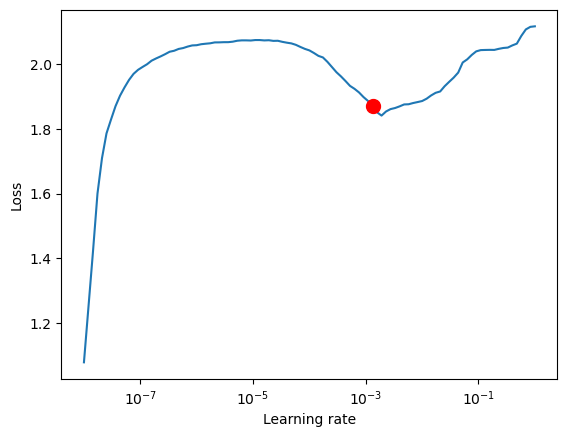

In [23]:
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
new_lr

In [24]:
# зададим новый Lr модели
new_lr = 0.0004
new_lr

0.0004

### Можем найти максимально возможный батч который влезет на нашу ГПУ

Не оптимальный размер батча для обучения, а именно максимально возможный на нашем оборудовании.

In [25]:
# model = LitModel((3, 224, 224), transfer=transfer_flag, learning_rate=new_lr)
# trainer = pl.Trainer(accelerator="gpu", auto_scale_batch_size="binsearch")

In [26]:
# call tune to find the batch size
# trainer.tune(model, dm)

### Непосредственно обучение модели

In [27]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

# создадим обратный вызов на раннюю остановку обучения
early_stop_callback = EarlyStopping(monitor="val_f1", patience=10, verbose=False, mode="max")

# создадим обратный вызов на сохранение чекпоинта модели,
# по интересующей нас метрике
# saves top-K checkpoints based on "val_loss" metric
checkpoint_callback_val_loss = ModelCheckpoint(
    save_top_k=5,
    monitor="val_loss",
    mode="min",
    filename="check_point-{epoch:02d}-{val_loss:.2f}",
)

# saves last-K checkpoints based on "global_step" metric
# make sure you log it inside your LightningModule
checkpoint_callback_last_step = ModelCheckpoint(
    save_top_k=1,
    monitor="train_step",
    mode="max",
    filename="check_point-{epoch:02d}-{train_step}",
)


### Обучение модели

In [28]:
# начинаем обучение модели

model = LitModel((3, 224, 224), emotion_num, fc_only=True, learning_rate=new_lr)

# добавляем список обратных вызовов в параметр callbacks
trainer = pl.Trainer(accelerator="gpu", 
                     callbacks=[early_stop_callback,
                                checkpoint_callback_val_loss,
                                checkpoint_callback_last_step],
                     max_epochs=10,
                     log_every_n_steps=10)

/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [29]:
# добавляем список обратных вызовов в параметр callbacks
trainer = pl.Trainer(accelerator="gpu", 
                     callbacks=[early_stop_callback,
                                checkpoint_callback_val_loss,
                                checkpoint_callback_last_step],
                     log_every_n_steps=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [30]:
trainer.fit(model, dm)

/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
-------------------------------------------------
0 | neural_net | ResNet            | 23.5 M
1 | metric     | MulticlassF1Score | 0     
-------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.098    Total estimated model pa

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [45]:
model = model.load_from_checkpoint("lightning_logs/version_1/checkpoints/check_point-epoch=10-val_loss=0.13.ckpt")

/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Протестируем полученную модель

In [ ]:
# можем проверить на тестовой части (подсунув вместо теста val)
# trainer.test(model, dm.val_dataloader())

In [46]:
# можем проверить на val части датасета
trainer.validate(model, dm)

You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_f1             0.9543136358261108
        val_loss            0.13473621010780334
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.13473621010780334, 'val_f1': 0.9543136358261108}]

## Загрузим желаемый чекпоинт

In [47]:
# disable randomness, dropout, etc...
model.eval();

## Сделаем предсказание

### Сделаем предсказание на val

Проверим, что функции предсказания работаю корректно.
И что мы получаем тот же самый результат по метрике MSE, что и раньше.

In [48]:
# predict with the model
preds = trainer.predict(model, dm.test_by_val_dataloader())


You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 426it [00:00, ?it/s]

In [50]:
preds

[[[-6.5445966720581055,
   -5.580397129058838,
   -8.342804908752441,
   0.6636018753051758,
   5.677524566650391,
   -5.690114498138428,
   -3.7706050872802734,
   -1.1539231538772583],
  [-3.237152099609375,
   9.1571626663208,
   -4.616177558898926,
   -3.6451611518859863,
   -10.362252235412598,
   -7.812016010284424,
   -7.144440174102783,
   -2.0198042392730713],
  [-3.2295453548431396,
   -5.24492883682251,
   -9.884978294372559,
   1.7870773077011108,
   -7.050579071044922,
   -0.9065347909927368,
   -5.747019290924072,
   2.8747129440307617],
  [-19.342735290527344,
   -7.8858113288879395,
   -11.160510063171387,
   1.891003966331482,
   -5.141931533813477,
   4.3920087814331055,
   8.026911735534668,
   -7.07429838180542],
  [-16.237821578979492,
   -8.59814739227295,
   -9.968825340270996,
   -4.1365556716918945,
   -2.7309064865112305,
   8.019920349121094,
   -1.374954342842102,
   -6.70833683013916],
  [-25.846576690673828,
   -7.913638591766357,
   -5.850627422332764,
  

array([-6.54459667, -3.2371521 , -3.22954535, ..., -5.97830629,
       -6.68190908, -1.66995704])

In [39]:
# Оценим нашу модель на валидационной выборке:
print(f"F1 = {f1_score(y_true, y_preds)}")

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

### Сделаем предсказание непосредственно на тесте

In [38]:
# predict with the model
preds = trainer.predict(model, dm.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 14it [00:00, ?it/s]

In [39]:
y_preds = []
for sublist in preds:
    for item in sublist:
        y_preds.append(item[0])
        
y_preds = np.array(y_preds)

In [40]:
y_preds

array([ 7.32678032, 11.18929768,  1.44223154, ..., 11.48866272,
        6.14334536,  2.86557984])

# публикуем сабмит

In [41]:
submission = pd.read_csv('data/sample_submission.csv')

In [42]:
submission

,label
0,0
1,0
2,0
3,0
4,0
...,...
5995,0
5996,0
5997,0
5998,0


In [43]:
submission['label'] = y_preds


In [44]:
submission

,label
0,7.326780
1,11.189298
2,1.442232
3,6.111101
4,8.025280
...,...
5995,12.518585
5996,9.975379
5997,11.488663
5998,6.143345


In [45]:
submission_path = 'submission/PyTorchLighnting_Resnet50.csv'

In [46]:
submission.to_csv(submission_path, index=False)

## Conclusion

I will encourage you to play with the code and train an image classifier with a dataset of your choice from scratch and using transfer learning. 


To learn more about transfer learning check out these resources:
- [Gotchas of transfer learning for image classification](https://docs.google.com/presentation/d/1s29WOQoQvBD5KoPUzE5TPcavjqno8ZgnZaSljHGGHVU/edit?usp=sharing) by Sayak Paul.
- [Transfer Learning with Keras and Deep Learning by PyImageSearch.](https://www.pyimagesearch.com/2019/05/20/transfer-learning-with-keras-and-deep-learning/)
- [Transfer Learning - Machine Learning's Next Frontier](https://ruder.io/transfer-learning/) by Sebastian Ruder.





